# Noisy Regularized Classifier with FMNIST

------------------------------------------------------
*Basic example of the behaviour of stochastic regularization layers in FMNIST classification*


------------------------------------------------------



Remember in our methodology, there are 4 main stages:
    1. Pre-training of the base architecture.
    2. Training GMVAE with some hidden vector within the base model.
    3. Integration of GMVAE in the base architecture.
    4. Finetuning layers and parameters above the place where the stochastic layer is placed.

## 1. Pre-training of the base architecture of the classifier


Firstly, we present the pre-training of the FMNIST as the initial step.

In [21]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt


In this example, we build two classes for the definition of the classification neural network:
 - Classifier: The raw version of the NN that is the original architecture without the regularizer. It is needed to do the pretraining and is described in the following cell. It is composed of a function, *obtain_input_to_regularize_lower*, in order to get the hidden vectors considered the input to the GMVAE. They are the vectors after the first layer, fc1.
 - NoRClassifier: This version is defined later in the notebook and it includes the GMVAE within the structure.

In [22]:
class Classifier(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(784, 700)
        self.fc2 = nn.Linear(700, 600)
        self.fc3 = nn.Linear(600, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc9 = nn.Linear(16, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.dropout(F.relu(self.fc8(x)))
        x = F.log_softmax(self.fc9(x), dim=1)
        return x

    def obtain_input_to_regularize_lower(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        return x.detach()



Parameters definition:

In [34]:
dropout = 0
epochs = 200
lr = 0.01
load_path = "200epochs_dp0_lr001"


Download dataset and transform images:

We normalize the images and build training, validation and test datasets.

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5,),)])

trainset = datasets.FashionMNIST('~/.python/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.python/F_MNIST_data', download=True, train=False, transform=transform)

indices = list(range(len(trainset)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


We create the Classifier model and define the criterion and optimizer used in the training step.

In [36]:
model = Classifier()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)


Training step:

In [37]:
valid_loss_min = np.Inf
steps = 0
train_losses, valid_losses = [], []
model.train()
for e in range(epochs):
    running_loss = 0
    valid_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)

    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()*images.size(0)

    running_loss = running_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1, running_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print('validation loss decreased({:.6f} -->{:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'saved/{}/model_pretrain{}.pt'.format(load_path, dropout))
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 2.314347 	Validation Loss: 2.310117
validation loss decreased(inf -->2.310117). Saving model ...
Epoch: 2 	Training Loss: 2.309818 	Validation Loss: 2.307090
validation loss decreased(2.310117 -->2.307090). Saving model ...
Epoch: 3 	Training Loss: 2.307009 	Validation Loss: 2.305363
validation loss decreased(2.307090 -->2.305363). Saving model ...
Epoch: 4 	Training Loss: 2.305267 	Validation Loss: 2.304313
validation loss decreased(2.305363 -->2.304313). Saving model ...
Epoch: 5 	Training Loss: 2.304359 	Validation Loss: 2.303791
validation loss decreased(2.304313 -->2.303791). Saving model ...
Epoch: 6 	Training Loss: 2.303360 	Validation Loss: 2.303380
validation loss decreased(2.303791 -->2.303380). Saving model ...
Epoch: 7 	Training Loss: 2.302857 	Validation Loss: 2.303191
validation loss decreased(2.303380 -->2.303191). Saving model ...
Epoch: 8 	Training Loss: 2.302865 	Validation Loss: 2.303206
Epoch: 9 	Training Loss: 2.302440 	Validation Loss: 2.3

Epoch: 75 	Training Loss: 0.698983 	Validation Loss: 0.847473
Epoch: 76 	Training Loss: 0.696908 	Validation Loss: 0.756770
validation loss decreased(0.799164 -->0.756770). Saving model ...
Epoch: 77 	Training Loss: 0.662660 	Validation Loss: 0.750899
validation loss decreased(0.756770 -->0.750899). Saving model ...
Epoch: 78 	Training Loss: 0.671168 	Validation Loss: 0.810436
Epoch: 79 	Training Loss: 0.620970 	Validation Loss: 0.799917
Epoch: 80 	Training Loss: 0.613795 	Validation Loss: 0.897918
Epoch: 81 	Training Loss: 0.608221 	Validation Loss: 0.840996
Epoch: 82 	Training Loss: 0.730733 	Validation Loss: 0.744379
validation loss decreased(0.750899 -->0.744379). Saving model ...
Epoch: 83 	Training Loss: 0.609216 	Validation Loss: 0.760167
Epoch: 84 	Training Loss: 0.579142 	Validation Loss: 0.781639
Epoch: 85 	Training Loss: 0.679981 	Validation Loss: 0.742264
validation loss decreased(0.744379 -->0.742264). Saving model ...
Epoch: 86 	Training Loss: 0.573556 	Validation Loss: 0

Epoch: 199 	Training Loss: 1.069337 	Validation Loss: 1.258136
Epoch: 200 	Training Loss: 0.246911 	Validation Loss: 1.069874


Plot the training and validation losses in every epoch.

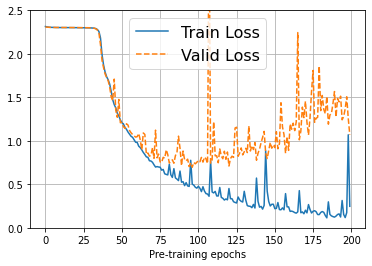

In [38]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss', linestyle='dashed')
plt.xlabel('Pre-training epochs')
plt.ylim((0, 2.5))
plt.legend(fontsize=16)
plt.grid(True)
plt.savefig('saved/{}/loss_pretrain{}.pdf'.format(load_path, dropout))
plt.show()

This plot helps the reader visualize the overfitting effect of the model, due to the huge size of the neural network in relation to the number of samples and the lack of regularization mechanisms. However, we save the best model in the training loop, before the validation loss starts to increase around epoch 100.

Load best model trained:

In [39]:
model.load_state_dict(torch.load('saved/{}/model_pretrain{}.pt'.format(load_path, dropout)))
model.eval()


Classifier(
  (fc1): Linear(in_features=784, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=32, bias=True)
  (fc8): Linear(in_features=32, out_features=16, bias=True)
  (fc9): Linear(in_features=16, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Print test results in order to visualize the images in the dataset and the samples which are more difficult to classify.

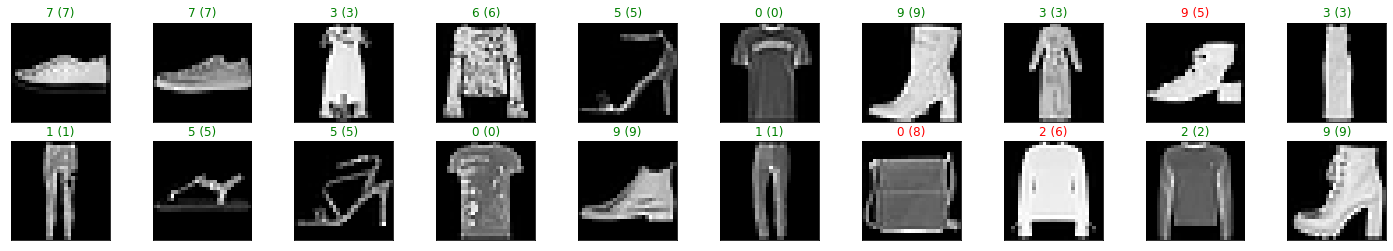

In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))




## 2. Training GMVAE with some hidden vectors within the base model.


In [41]:
import sys, os


We include some libraries and scripts with the GMVAE definition and with the suitable functions to train it.

In [43]:
add_path = './GMVAE'
sys.path.append(os.path.abspath(add_path))

from GMVAE import *
from utils import *

We define all the paraemters for the GMVAE model

In [47]:
print('\n Loading parameters...')

config = Bunch()

config.name_extension = ""
config.dataset_name = "FMNIST_" + load_path
config.dataroot = ""
config.train_dataroot = ""
config.test_dataroot = ""
config.cuda = 0
config.device = 0
config.epochs = 400
config.batch_size = 64
config.l_rate = 1e-3
config.dropout = 0.3
config.weight_decay = 0
config.hidden_dim = 50
config.sigma = 1e-4
config.z_dim = 25
config.w_dim = 25
config.K = 10
config.layers = 3
config.remove = 1
config.checkpoint_dir = "checkpoints"
config.result_dir = "results"
config.board_dir = "summary"
config.train = 1
config.summary = 1 
config.plot = 0
config.restore = 0
config.results = 1
config.verbose = 1
config.extra = ""
config.step_restore = 400
config.checkpoint_step = 10
config.option = 1


# capture the config path from the input arguments
config.model_name = get_model_name(config)

if (config.extra is not ''):
    config.model_name += '_' + config.extra

config.board_dir = os.path.join("experiments/" + config.dataset_name + '/' + config.board_dir + "/",
                                config.model_name)
config.checkpoint_dir = os.path.join("experiments/" + config.dataset_name + '/' + config.checkpoint_dir + "/",
                                     config.model_name)
config.result_dir = os.path.join("experiments/" + config.dataset_name + '/' + config.result_dir + "/",
                                 config.model_name)

flags = Bunch()
flags.train = config['train']
flags.summary = config['summary']
flags.restore = config['restore']
flags.verbose = config['verbose']
flags.results = config['results']


# Create the experiment directories
create_dirs([config.board_dir, config.checkpoint_dir, config.result_dir])

# Save configuration arguments in a txt
save_args(config, config.board_dir)

# Set GPU configuration
if config.cuda and torch.cuda.is_available():
    torch.cuda.set_device(config.device)
else:
    print('cuda set to False')
    config.cuda = 0

config.input_dim = 700


print('='*100)
print('PARAMETERS AND CONFIGURATION')
for k, v in config.items(): print('- {}: {}'.format(k, v))
print('='*100 + '\n')


 Loading parameters...
cuda set to False
PARAMETERS AND CONFIGURATION
- name_extension: 
- dataset_name: FMNIST_200epochs_dp0_lr001
- dataroot: 
- train_dataroot: 
- test_dataroot: 
- cuda: 0
- device: 0
- epochs: 400
- batch_size: 64
- l_rate: 0.001
- dropout: 0.3
- weight_decay: 0
- hidden_dim: 50
- sigma: 0.0001
- z_dim: 25
- w_dim: 25
- K: 10
- layers: 3
- remove: 1
- checkpoint_dir: experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001
- result_dir: experiments/FMNIST_200epochs_dp0_lr001/results/GMVAE_1_00001_25_25_10_50_3_03_0001
- board_dir: experiments/FMNIST_200epochs_dp0_lr001/summary/GMVAE_1_00001_25_25_10_50_3_03_0001
- train: 1
- summary: 1
- plot: 0
- restore: 0
- results: 1
- verbose: 1
- extra: 
- step_restore: 400
- checkpoint_step: 10
- option: 1
- model_name: GMVAE_1_00001_25_25_10_50_3_03_0001
- input_dim: 700



We load the pre-trained model because we need it to compute the inputs to the GMVAE, that is, the hidden vectors after the first layer that we are going to regularize.

In [48]:
model = Classifier()

model.load_state_dict(torch.load('saved/{}/model_pretrain0.pt'.format(load_path)))
model.eval()

Classifier(
  (fc1): Linear(in_features=784, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=32, bias=True)
  (fc8): Linear(in_features=32, out_features=16, bias=True)
  (fc9): Linear(in_features=16, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

We load the dataset and use the function *obtain_input_to_regularize_lower* from the Classifier to transform the original images to the hidden vector in target.

In [49]:
transform_GMVAE = transforms.Compose([transforms.ToTensor(), model.obtain_input_to_regularize_lower])

trainset_GMVAE = datasets.FashionMNIST('~/.python/F_MNIST_data', download=True, train=True, transform=transform_GMVAE)

indices = list(range(len(trainset_GMVAE)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(trainset_GMVAE)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

trainloader_GMVAE = torch.utils.data.DataLoader(trainset_GMVAE, sampler=train_sample, batch_size=64)
validloader_GMVAE = torch.utils.data.DataLoader(trainset_GMVAE, sampler=valid_sample, batch_size=64)


Build the GMVAE model with the parameters defined above.

In [50]:
print('\n Building computation graph...')
GMVAE_model = GMVAE(config)


 Building computation graph...
Saving config to "experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001/config.pt".



Train the GMVAE model the the cofiguration and the inputs defined before.

In [51]:
GMVAE_model.train(trainloader_GMVAE, validloader_GMVAE)

Trainable params: 203260
(Epoch 1 / 400)
Train - Log-lik: -117049.85325;  CP: 25.42033;  KL_w: 0.11260;  KL_y: 0.04933;
Valid - Log-lik: -54213.86672;  CP: 40.18926;  KL_w: 0.00376;  KL_y: 0.09635;
Total Loss=Train: 117075.43420; Val: 54254.15625
(Epoch 2 / 400)
Train - Log-lik: -57868.09664;  CP: 47.76927;  KL_w: 0.02192;  KL_y: 0.19268;
Valid - Log-lik: -42040.81509;  CP: 53.40542;  KL_w: 0.00118;  KL_y: 0.29125;
Total Loss=Train: 57916.08024; Val: 42094.51169
(Epoch 3 / 400)
Train - Log-lik: -49487.34803;  CP: 57.61246;  KL_w: 0.01059;  KL_y: 0.46478;
Valid - Log-lik: -36401.61922;  CP: 60.94118;  KL_w: 0.00047;  KL_y: 0.67526;
Total Loss=Train: 49545.43573; Val: 36463.23568
(Epoch 4 / 400)
Train - Log-lik: -45126.34192;  CP: 64.41055;  KL_w: 0.00719;  KL_y: 0.72697;
Valid - Log-lik: -33142.58237;  CP: 67.12546;  KL_w: 0.00010;  KL_y: 0.80403;
Total Loss=Train: 45191.48689; Val: 33210.51187
(Epoch 5 / 400)
Train - Log-lik: -43648.70805;  CP: 69.90003;  KL_w: 0.00576;  KL_y: 0.88773;

(Epoch 34 / 400)
Train - Log-lik: -37323.81902;  CP: 86.36303;  KL_w: 0.00002;  KL_y: 1.51516;
Valid - Log-lik: -29560.50840;  CP: 84.50493;  KL_w: 0.00001;  KL_y: 1.57970;
Total Loss=Train: 37411.69733; Val: 29646.59300
(Epoch 35 / 400)
Train - Log-lik: -37145.16475;  CP: 85.52984;  KL_w: 0.00002;  KL_y: 1.51586;
Valid - Log-lik: -29398.65110;  CP: 84.67166;  KL_w: 0.00001;  KL_y: 1.61050;
Total Loss=Train: 37232.21039; Val: 29484.93328
(Epoch 36 / 400)
Train - Log-lik: -36989.84103;  CP: 86.14948;  KL_w: 0.00002;  KL_y: 1.52910;
Valid - Log-lik: -29074.62070;  CP: 85.04011;  KL_w: 0.00001;  KL_y: 1.56140;
Total Loss=Train: 37077.51951; Val: 29161.22219
(Epoch 37 / 400)
Train - Log-lik: -36899.51346;  CP: 86.35504;  KL_w: 0.00001;  KL_y: 1.52570;
Valid - Log-lik: -28382.92288;  CP: 85.87227;  KL_w: 0.00001;  KL_y: 1.61016;
Total Loss=Train: 36987.39434; Val: 28470.40530
(Epoch 38 / 400)
Train - Log-lik: -36804.37411;  CP: 86.83154;  KL_w: 0.00001;  KL_y: 1.53635;
Valid - Log-lik: -287

(Epoch 67 / 400)
Train - Log-lik: -34450.90625;  CP: 90.43086;  KL_w: 0.00001;  KL_y: 1.54177;
Valid - Log-lik: -25703.45790;  CP: 90.33274;  KL_w: 0.00001;  KL_y: 1.64634;
Total Loss=Train: 34542.87886; Val: 25795.43702
(Epoch 68 / 400)
Train - Log-lik: -34345.83070;  CP: 91.29616;  KL_w: 0.00001;  KL_y: 1.54001;
Valid - Log-lik: -25751.61899;  CP: 86.93736;  KL_w: 0.00001;  KL_y: 1.60459;
Total Loss=Train: 34438.66691; Val: 25840.16097
(Epoch 69 / 400)
Train - Log-lik: -34224.37874;  CP: 91.04556;  KL_w: 0.00001;  KL_y: 1.54104;
Valid - Log-lik: -25543.14645;  CP: 90.25777;  KL_w: 0.00000;  KL_y: 1.62137;
Total Loss=Train: 34316.96550; Val: 25635.02561
(Epoch 70 / 400)
Train - Log-lik: -34241.10112;  CP: 91.85769;  KL_w: 0.00001;  KL_y: 1.54102;
Valid - Log-lik: -25714.44785;  CP: 90.60982;  KL_w: 0.00001;  KL_y: 1.62052;
Total Loss=Train: 34334.49990; Val: 25806.67820
Saving checkpoint to "experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001/step_70

(Epoch 100 / 400)
Train - Log-lik: -33497.78265;  CP: 93.55436;  KL_w: 0.00001;  KL_y: 1.50716;
Valid - Log-lik: -24961.77035;  CP: 92.96707;  KL_w: 0.00001;  KL_y: 1.60655;
Total Loss=Train: 33592.84423; Val: 25056.34396
Saving checkpoint to "experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001/step_100.pt".

(Epoch 101 / 400)
Train - Log-lik: -33384.50774;  CP: 93.01603;  KL_w: 0.00001;  KL_y: 1.50123;
Valid - Log-lik: -25039.90318;  CP: 91.65249;  KL_w: 0.00001;  KL_y: 1.59144;
Total Loss=Train: 33479.02501; Val: 25133.14706
(Epoch 102 / 400)
Train - Log-lik: -33402.39265;  CP: 92.71432;  KL_w: 0.00001;  KL_y: 1.50201;
Valid - Log-lik: -25089.37771;  CP: 91.63320;  KL_w: 0.00001;  KL_y: 1.58979;
Total Loss=Train: 33496.60885; Val: 25182.60069
(Epoch 103 / 400)
Train - Log-lik: -33433.01549;  CP: 93.08513;  KL_w: 0.00001;  KL_y: 1.50720;
Valid - Log-lik: -25201.60916;  CP: 92.07523;  KL_w: 0.00001;  KL_y: 1.58142;
Total Loss=Train: 33527.60780; Val: 

(Epoch 132 / 400)
Train - Log-lik: -33021.25396;  CP: 93.02869;  KL_w: 0.00001;  KL_y: 1.47806;
Valid - Log-lik: -25205.62085;  CP: 92.58450;  KL_w: 0.00000;  KL_y: 1.55342;
Total Loss=Train: 33115.76081; Val: 25299.75878
(Epoch 133 / 400)
Train - Log-lik: -33116.86527;  CP: 93.09646;  KL_w: 0.00000;  KL_y: 1.47627;
Valid - Log-lik: -25285.88113;  CP: 93.49774;  KL_w: 0.00000;  KL_y: 1.59318;
Total Loss=Train: 33211.43793; Val: 25380.97206
(Epoch 134 / 400)
Train - Log-lik: -33112.59377;  CP: 94.65851;  KL_w: 0.00000;  KL_y: 1.48564;
Valid - Log-lik: -24652.85361;  CP: 93.47083;  KL_w: 0.00000;  KL_y: 1.57299;
Total Loss=Train: 33208.73798; Val: 24747.89746
(Epoch 135 / 400)
Train - Log-lik: -33168.32809;  CP: 94.11413;  KL_w: 0.00001;  KL_y: 1.49264;
Valid - Log-lik: -24761.27516;  CP: 93.14023;  KL_w: 0.00000;  KL_y: 1.58075;
Total Loss=Train: 33263.93492; Val: 24855.99611
(Epoch 136 / 400)
Train - Log-lik: -33143.99752;  CP: 94.14265;  KL_w: 0.00000;  KL_y: 1.48774;
Valid - Log-lik:

(Epoch 165 / 400)
Train - Log-lik: -32841.28226;  CP: 93.14159;  KL_w: 0.00001;  KL_y: 1.50137;
Valid - Log-lik: -24942.05412;  CP: 92.60593;  KL_w: 0.00000;  KL_y: 1.59157;
Total Loss=Train: 32935.92524; Val: 25036.25161
(Epoch 166 / 400)
Train - Log-lik: -32779.50814;  CP: 93.59482;  KL_w: 0.00001;  KL_y: 1.50037;
Valid - Log-lik: -24436.83729;  CP: 93.23100;  KL_w: 0.00001;  KL_y: 1.57080;
Total Loss=Train: 32874.60335; Val: 24531.63907
(Epoch 167 / 400)
Train - Log-lik: -32894.78044;  CP: 93.13429;  KL_w: 0.00001;  KL_y: 1.49251;
Valid - Log-lik: -24722.93390;  CP: 93.26069;  KL_w: 0.00000;  KL_y: 1.57723;
Total Loss=Train: 32989.40720; Val: 24817.77178
(Epoch 168 / 400)
Train - Log-lik: -32973.20958;  CP: 92.68083;  KL_w: 0.00001;  KL_y: 1.49365;
Valid - Log-lik: -24769.61151;  CP: 90.55009;  KL_w: 0.00000;  KL_y: 1.59388;
Total Loss=Train: 33067.38393; Val: 24861.75551
(Epoch 169 / 400)
Train - Log-lik: -32893.84934;  CP: 92.69590;  KL_w: 0.00000;  KL_y: 1.49825;
Valid - Log-lik:

(Epoch 198 / 400)
Train - Log-lik: -32732.09106;  CP: 92.08517;  KL_w: 0.00000;  KL_y: 1.48219;
Valid - Log-lik: -24644.08048;  CP: 91.97928;  KL_w: 0.00000;  KL_y: 1.55369;
Total Loss=Train: 32825.65861; Val: 24737.61344
(Epoch 199 / 400)
Train - Log-lik: -32779.07157;  CP: 91.59223;  KL_w: 0.00000;  KL_y: 1.48240;
Valid - Log-lik: -24767.23165;  CP: 91.15565;  KL_w: 0.00000;  KL_y: 1.56467;
Total Loss=Train: 32872.14627; Val: 24859.95198
(Epoch 200 / 400)
Train - Log-lik: -32804.92834;  CP: 92.78247;  KL_w: 0.00000;  KL_y: 1.48488;
Valid - Log-lik: -24509.78018;  CP: 91.32973;  KL_w: 0.00000;  KL_y: 1.58488;
Total Loss=Train: 32899.19569; Val: 24602.69479
Saving checkpoint to "experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001/step_200.pt".

(Epoch 201 / 400)
Train - Log-lik: -32778.68689;  CP: 93.00811;  KL_w: 0.00001;  KL_y: 1.48447;
Valid - Log-lik: -24832.08087;  CP: 92.70443;  KL_w: 0.00000;  KL_y: 1.53387;
Total Loss=Train: 32873.17956; Val: 

(Epoch 231 / 400)
Train - Log-lik: -32663.49583;  CP: 93.32321;  KL_w: 0.00000;  KL_y: 1.46530;
Valid - Log-lik: -24288.86647;  CP: 92.35180;  KL_w: 0.00000;  KL_y: 1.51695;
Total Loss=Train: 32758.28428; Val: 24382.73523
(Epoch 232 / 400)
Train - Log-lik: -32724.75325;  CP: 93.12778;  KL_w: 0.00000;  KL_y: 1.46015;
Valid - Log-lik: -24327.14299;  CP: 90.67425;  KL_w: 0.00000;  KL_y: 1.53000;
Total Loss=Train: 32819.34112; Val: 24419.34724
(Epoch 233 / 400)
Train - Log-lik: -32628.98856;  CP: 92.03568;  KL_w: 0.00000;  KL_y: 1.46716;
Valid - Log-lik: -24451.79136;  CP: 91.71408;  KL_w: 0.00000;  KL_y: 1.51255;
Total Loss=Train: 32722.49151; Val: 24545.01796
(Epoch 234 / 400)
Train - Log-lik: -32593.95067;  CP: 92.35972;  KL_w: 0.00000;  KL_y: 1.46871;
Valid - Log-lik: -24252.72423;  CP: 90.92870;  KL_w: 0.00000;  KL_y: 1.53403;
Total Loss=Train: 32687.77905; Val: 24345.18696
(Epoch 235 / 400)
Train - Log-lik: -32585.60004;  CP: 91.43274;  KL_w: 0.00000;  KL_y: 1.47014;
Valid - Log-lik:

(Epoch 264 / 400)
Train - Log-lik: -32581.86433;  CP: 91.42769;  KL_w: 0.00000;  KL_y: 1.48131;
Valid - Log-lik: -24103.12324;  CP: 90.04703;  KL_w: 0.00001;  KL_y: 1.55333;
Total Loss=Train: 32674.77332; Val: 24194.72359
(Epoch 265 / 400)
Train - Log-lik: -32380.25465;  CP: 91.73862;  KL_w: 0.00000;  KL_y: 1.48257;
Valid - Log-lik: -24468.65859;  CP: 91.29764;  KL_w: 0.00001;  KL_y: 1.57679;
Total Loss=Train: 32473.47578; Val: 24561.53302
(Epoch 266 / 400)
Train - Log-lik: -32491.09347;  CP: 92.02151;  KL_w: 0.00001;  KL_y: 1.47908;
Valid - Log-lik: -23937.44168;  CP: 91.67632;  KL_w: 0.00000;  KL_y: 1.52080;
Total Loss=Train: 32584.59408; Val: 24030.63879
(Epoch 267 / 400)
Train - Log-lik: -32388.77664;  CP: 91.52096;  KL_w: 0.00000;  KL_y: 1.48664;
Valid - Log-lik: -24532.00914;  CP: 89.93377;  KL_w: 0.00000;  KL_y: 1.54123;
Total Loss=Train: 32481.78425; Val: 24623.48412
(Epoch 268 / 400)
Train - Log-lik: -32495.34584;  CP: 91.19221;  KL_w: 0.00000;  KL_y: 1.48257;
Valid - Log-lik:

(Epoch 297 / 400)
Train - Log-lik: -32428.54060;  CP: 91.10134;  KL_w: 0.00000;  KL_y: 1.47995;
Valid - Log-lik: -24350.32854;  CP: 89.95817;  KL_w: 0.00000;  KL_y: 1.54160;
Total Loss=Train: 32521.12183; Val: 24441.82831
(Epoch 298 / 400)
Train - Log-lik: -32441.98989;  CP: 90.14399;  KL_w: 0.00000;  KL_y: 1.47445;
Valid - Log-lik: -23876.16511;  CP: 88.75777;  KL_w: 0.00000;  KL_y: 1.49656;
Total Loss=Train: 32533.60834; Val: 23966.41939
(Epoch 299 / 400)
Train - Log-lik: -32482.52911;  CP: 88.97452;  KL_w: 0.00000;  KL_y: 1.47091;
Valid - Log-lik: -24321.13517;  CP: 88.13527;  KL_w: 0.00000;  KL_y: 1.53299;
Total Loss=Train: 32572.97454; Val: 24410.80346
(Epoch 300 / 400)
Train - Log-lik: -32493.31243;  CP: 88.71012;  KL_w: 0.00000;  KL_y: 1.47733;
Valid - Log-lik: -24045.25073;  CP: 87.64849;  KL_w: 0.00000;  KL_y: 1.55521;
Total Loss=Train: 32583.49999; Val: 24134.45435
Saving checkpoint to "experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001/ste

(Epoch 330 / 400)
Train - Log-lik: -32354.09412;  CP: 87.00433;  KL_w: 0.00000;  KL_y: 1.48807;
Valid - Log-lik: -23927.77192;  CP: 86.44953;  KL_w: 0.00000;  KL_y: 1.49146;
Total Loss=Train: 32442.58655; Val: 24015.71289
Saving checkpoint to "experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001/step_330.pt".

(Epoch 331 / 400)
Train - Log-lik: -32299.60451;  CP: 87.81912;  KL_w: 0.00000;  KL_y: 1.48712;
Valid - Log-lik: -23803.76506;  CP: 88.13517;  KL_w: 0.00000;  KL_y: 1.56543;
Total Loss=Train: 32388.91083; Val: 23893.46569
(Epoch 332 / 400)
Train - Log-lik: -32376.74803;  CP: 88.70439;  KL_w: 0.00000;  KL_y: 1.49388;
Valid - Log-lik: -23940.80135;  CP: 87.37497;  KL_w: 0.00000;  KL_y: 1.54100;
Total Loss=Train: 32466.94621; Val: 24029.71727
(Epoch 333 / 400)
Train - Log-lik: -32392.09999;  CP: 87.89958;  KL_w: 0.00000;  KL_y: 1.49402;
Valid - Log-lik: -24097.44638;  CP: 85.86557;  KL_w: 0.00001;  KL_y: 1.51786;
Total Loss=Train: 32481.49352; Val: 

(Epoch 362 / 400)
Train - Log-lik: -32333.28291;  CP: 85.77353;  KL_w: 0.00000;  KL_y: 1.52821;
Valid - Log-lik: -24014.86626;  CP: 85.88484;  KL_w: 0.00000;  KL_y: 1.55409;
Total Loss=Train: 32420.58456; Val: 24102.30516
(Epoch 363 / 400)
Train - Log-lik: -32348.29726;  CP: 85.58263;  KL_w: 0.00000;  KL_y: 1.51928;
Valid - Log-lik: -23915.66323;  CP: 85.06009;  KL_w: 0.00000;  KL_y: 1.56175;
Total Loss=Train: 32435.39920; Val: 24002.28508
(Epoch 364 / 400)
Train - Log-lik: -32349.65020;  CP: 86.05990;  KL_w: 0.00000;  KL_y: 1.51426;
Valid - Log-lik: -24402.16627;  CP: 85.47127;  KL_w: 0.00001;  KL_y: 1.57654;
Total Loss=Train: 32437.22450; Val: 24489.21413
(Epoch 365 / 400)
Train - Log-lik: -32479.81899;  CP: 85.48958;  KL_w: 0.00000;  KL_y: 1.52076;
Valid - Log-lik: -24212.63137;  CP: 84.49838;  KL_w: 0.00000;  KL_y: 1.54782;
Total Loss=Train: 32566.82940; Val: 24298.67753
(Epoch 366 / 400)
Train - Log-lik: -32434.60793;  CP: 85.39272;  KL_w: 0.00000;  KL_y: 1.52037;
Valid - Log-lik:

(Epoch 395 / 400)
Train - Log-lik: -32314.88192;  CP: 84.25094;  KL_w: 0.00000;  KL_y: 1.61111;
Valid - Log-lik: -24313.41489;  CP: 83.21826;  KL_w: 0.00000;  KL_y: 1.65140;
Total Loss=Train: 32400.74393; Val: 24398.28453
(Epoch 396 / 400)
Train - Log-lik: -32424.59654;  CP: 83.35148;  KL_w: 0.00000;  KL_y: 1.61762;
Valid - Log-lik: -24182.80211;  CP: 82.96985;  KL_w: 0.00000;  KL_y: 1.66553;
Total Loss=Train: 32509.56564; Val: 24267.43749
(Epoch 397 / 400)
Train - Log-lik: -32399.57219;  CP: 84.69963;  KL_w: 0.00000;  KL_y: 1.61248;
Valid - Log-lik: -24171.29461;  CP: 82.81518;  KL_w: 0.00000;  KL_y: 1.65431;
Total Loss=Train: 32485.88423; Val: 24255.76410
(Epoch 398 / 400)
Train - Log-lik: -32246.78798;  CP: 83.39038;  KL_w: 0.00001;  KL_y: 1.61902;
Valid - Log-lik: -24062.71658;  CP: 82.89705;  KL_w: 0.00000;  KL_y: 1.67593;
Total Loss=Train: 32331.79743; Val: 24147.28953
(Epoch 399 / 400)
Train - Log-lik: -32380.68969;  CP: 83.66306;  KL_w: 0.00000;  KL_y: 1.61781;
Valid - Log-lik:

## 3-4. Integration of GMVAE and fine-tuning the NoRClassifier


Once we have pre-trained the classification neural network and trained the GMVAE with the suitable hidden vectors obtained from the pre-trained classifier, it is time to integrate both models in one and perform the fine-tuning step. For that, we define the new module class NoRCLassifier, whose forward function has a parameter with the GMVAE model. Between layers 1 and 2, we call the reconstruction function of the GMVAE so we obtain a new noisy version of the hidden vectors through the application of the inference and generation networks from the GMVAE.

In [52]:
class NoRClassifier(nn.Module):
    def __init__(self, freeze_lower=False, dropout_lower=False, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(784, 700)
        self.fc2 = nn.Linear(700, 600)
        self.fc3 = nn.Linear(600, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc9 = nn.Linear(16, 10)

        self.dropout_lower = dropout_lower

        self.dropout = nn.Dropout(dropout)

        # Freeze bert layers
        if freeze_lower:
            for p in self.fc1.parameters():
                p.requires_grad = False

    def forward(self, x, GMVAE=None):
        x = x.view(x.shape[0], -1)
        if self.dropout_lower:
            x = self.dropout(F.relu(self.fc1(x)))
        else:
            x = F.relu(self.fc1(x))

        if GMVAE != None:
            if GMVAE.cuda:
                x = torch.Tensor(GMVAE.batch_reconstruction(x.cuda())).cuda()
            else:
                x = torch.Tensor(GMVAE.batch_reconstruction(x))

        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.log_softmax(self.fc9(x), dim=1)
        return x


We define some new parameters in case we want to modify the number epochs from the pre-training, include some clarification tag in the model being ejecuted or freeze the first layer in the NN architecture.

In [53]:
epochs = 200
version = "lower_dp0" 
freeze_lower = True 
dropoutLower = False

We call the GMVAE trained before in an evaluation approach:

In [54]:
print('\n Building computation graph...')
GMVAE_model = GMVAE(config)

GMVAE_model.restore_model()

GMVAE_model.inference.eval()
GMVAE_model.generative.eval()


 Building computation graph...
Saving config to "experiments/FMNIST_200epochs_dp0_lr001/checkpoints/GMVAE_1_00001_25_25_10_50_3_03_0001/config.pt".

Loading model from checkpoint in step 400...


GenerativeNet(
  (activation): Tanh()
  (qz_wy_mean_layers): ModuleList(
    (0): Linear(in_features=25, out_features=50, bias=True)
    (1): Tanh()
  )
  (qz_wy_var_layers): ModuleList(
    (0): Linear(in_features=25, out_features=50, bias=True)
    (1): Tanh()
  )
  (px_z_mean_layers): ModuleList(
    (0): Linear(in_features=25, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=50, out_features=700, bias=True)
  )
)

We build the NoRClassifier model, loading the parameters from the best epoch in the pre-trianing stage:

In [55]:
model = NoRClassifier(freeze_lower=freeze_lower, dropout_lower=dropoutLower, dropout=dropout)

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

model.load_state_dict(torch.load('saved/{}/model_pretrain{}.pt'.format(load_path, dropout)))



<All keys matched successfully>

We compute the training loop:

In [56]:
valid_loss_min = np.Inf
model.train()
train_losses, valid_losses = [], []
for e in range(epochs):
    running_loss = 0
    valid_loss = 0

    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images, GMVAE=GMVAE_model)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)

    for images, labels in validloader:
        log_ps = model(images, GMVAE=GMVAE_model)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()*images.size(0)

    running_loss = running_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1, running_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print('validation loss decreased({:.6f} -->{:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'saved/{}/model_GMVAE_{}epochs_{}.pt'.format(load_path, epochs, version))
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.997701 	Validation Loss: 0.962763
validation loss decreased(inf -->0.962763). Saving model ...
Epoch: 2 	Training Loss: 0.876647 	Validation Loss: 0.925469
validation loss decreased(0.962763 -->0.925469). Saving model ...
Epoch: 3 	Training Loss: 0.839163 	Validation Loss: 0.913746
validation loss decreased(0.925469 -->0.913746). Saving model ...
Epoch: 4 	Training Loss: 0.811111 	Validation Loss: 0.852071
validation loss decreased(0.913746 -->0.852071). Saving model ...
Epoch: 5 	Training Loss: 0.794346 	Validation Loss: 0.873905
Epoch: 6 	Training Loss: 0.778565 	Validation Loss: 0.827654
validation loss decreased(0.852071 -->0.827654). Saving model ...
Epoch: 7 	Training Loss: 0.762458 	Validation Loss: 0.801411
validation loss decreased(0.827654 -->0.801411). Saving model ...
Epoch: 8 	Training Loss: 0.756068 	Validation Loss: 0.816322
Epoch: 9 	Training Loss: 0.743602 	Validation Loss: 0.773905
validation loss decreased(0.801411 -->0.773905). Saving mode

Epoch: 107 	Training Loss: 0.563862 	Validation Loss: 0.655319
Epoch: 108 	Training Loss: 0.554509 	Validation Loss: 0.654907
Epoch: 109 	Training Loss: 0.556321 	Validation Loss: 0.771678
Epoch: 110 	Training Loss: 0.560140 	Validation Loss: 0.733548
Epoch: 111 	Training Loss: 0.555700 	Validation Loss: 0.655994
Epoch: 112 	Training Loss: 0.555758 	Validation Loss: 0.708918
Epoch: 113 	Training Loss: 0.554713 	Validation Loss: 0.667323
Epoch: 114 	Training Loss: 0.555036 	Validation Loss: 0.754547
Epoch: 115 	Training Loss: 0.557369 	Validation Loss: 0.655965
Epoch: 116 	Training Loss: 0.552373 	Validation Loss: 0.651295
Epoch: 117 	Training Loss: 0.552417 	Validation Loss: 0.649620
Epoch: 118 	Training Loss: 0.551810 	Validation Loss: 0.642684
Epoch: 119 	Training Loss: 0.552809 	Validation Loss: 0.657275
Epoch: 120 	Training Loss: 0.550748 	Validation Loss: 0.675341
Epoch: 121 	Training Loss: 0.546530 	Validation Loss: 0.735814
Epoch: 122 	Training Loss: 0.551463 	Validation Loss: 0

Finally, we plot the losses in the fine-tuning stage.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


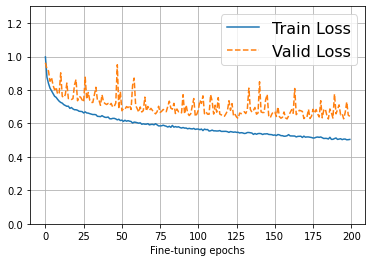

In [57]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss', linestyle='dashed')
plt.xlabel('Fine-tuning epochs')
plt.ylim((0, 1.3))
plt.legend(fontsize=16)
plt.grid(True)
plt.savefig('saved/{}/loss_GMVAE_{}epochs_{}.eps'.format(load_path, epochs, version))
plt.show()


This figure shows the slow overfitting effect, reduced thanks to the stochastic layer and the noisy version of the hidden vectors that it gets.

In case we want to train the baseline example, without the GMVAE and including dropout, we can modify the previous lines, and add the line *GMVAE_model = None* as well as set some dropout and define to True the dropoutLower flag.